In [8]:
import pandas as pd 
import networkx as nx 
from cdlib import algorithms
import numpy as np
from matplotlib import pyplot as plt
import sknetwork as skn
from sknetwork.embedding import Spectral
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import torch 

import os

In [372]:
print('loading tissue specific PPI graphs...')
tissues = {}
for net in os.listdir('../data/bio-tissue-networks/'): 
    tissue = net.split('.')[0]
    ppi = pd.read_csv(f'../data/bio-tissue-networks/{tissue}.edgelist', sep='\t', header=None).rename({0:'source', 1:'target'}, axis=1)
    G = nx.from_pandas_edgelist(ppi)
    A = nx.adj_matrix(G, nodelist=G.nodes()).todense()
    nodelist = list(G.nodes())
    temp = True
    train_mask = np.random.choice([True, False], p=[0.6, 0.4], size=A.shape[0])
    test_mask = ~train_mask
    tissues[tissue] = {'adjacency':A, 
                        'train_mask':train_mask,
                        'test_mask':test_mask,
                        'node_list':nodelist}

loading tissue specific PPI graphs...


In [325]:
print('loading labels...')
processes = {} 
for i,label in enumerate([x for x in os.listdir('../data/bio-tissue-labels/') if x not in ['INFO.txt']]):
    proc = 'GO:' + label.split('GO:')[-1].split('.')[0]
    tissue = label.split('GO:')[0][:-1]
    labels = pd.read_csv(f'../data/bio-tissue-labels/{label}', sep='\t', header=None, skiprows=1).rename({0:'gene', 1:'is_member'}, axis=1).set_index('gene')
    
    if proc not in processes: 
        processes[proc] = {tissue: labels}
    else: 
        processes[proc][tissue] = labels 
            

loading labels...


In [279]:
print('# biological processes:', len(processes))

# biological processes: 420


In [284]:
print('avg # tissues with per process', np.mean([len(v['tissue']) for k,v in processes.items()]))
print('median # tissues with per process', np.median([len(v['tissue']) for k,v in processes.items()]))
print('max # tissues with per process', np.min([len(v['tissue']) for k,v in processes.items()]))
print('min # tissues with per process', np.max([len(v['tissue']) for k,v in processes.items()]))

avg # tissues with per process 1.1976190476190476
median # tissues with per process 1.0
max # tissues with per process 1
min # tissues with per process 3


In [388]:
class GNN(torch.nn.Module): 
    def __init__(self, input, channels, output, dropout=0.0): 
        super(GNN, self).__init__() 
        self.f1 = torch.nn.Linear(input, channels)
        self.f2 = torch.nn.Linear(channels, channels)
        self.f3 = torch.nn.Linear(channels, channels)
        self.f_out = torch.nn.Sequential(torch.nn.Linear(channels, channels), torch.nn.ReLU(), torch.nn.Linear(channels, output))
        self.nonlin = torch.nn.ReLU()
        self.do = torch.nn.Dropout(dropout)

    def norm_adj(self, A): 
        '''
        normalize by GCN method
        '''
        Dinv = torch.diag_embed(torch.pow(A.sum(dim=-1),-0.5))
        return Dinv @ A @ Dinv

    def forward(self, A, x):  

        A = self.norm_adj(A)
        
        h1 = A @ self.f1(x)
        h1 = self.nonlin(h1)
        h1 = self.do(h1)

        h2 = A @ self.f2(h1)
        h2 = self.nonlin(h2)
        h2 = self.do(h2)

        h3 = A @ self.f3(h2)
        h3 = self.nonlin(h3)
        h3 = self.do(h3)

        return torch.sigmoid( self.f_out(h3) ).squeeze()

In [392]:
model = GNN(1, 100, len(processes), dropout=0.05)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.BCELoss(reduction='none')

In [393]:
def get_data(labels, tiss): 
    '''
    '''
    A = torch.tensor(tiss['adjacency'], dtype=torch.float) 

    # NOTE: this is now a weighted network (self edges will be 2 if there was an edge already)
    A = A + torch.eye(A.size(0), dtype=torch.float) 

    x = torch.ones((A.size(0),1), dtype=torch.float)
    y = torch.tensor(labels.loc[tiss['node_list'], :].values, dtype=torch.float)
    train_mask = torch.tensor(tiss['train_mask'])
    test_mask = torch.tensor(tiss['test_mask'])

    weights = torch.ones_like(y[train_mask])
    n_neg = (y[train_mask] == 0).sum()
    n_pos = (y[train_mask] == 1).sum()
    weights[y[train_mask] == 1] = n_neg / n_pos

    return A,x,y,train_mask,test_mask,weights

In [396]:
model = model.train()

for epoch in range(5000):
    test_roc = []
    train_roc = []
    test_acc = [] 
    train_acc = []

    proc_idx = 0
    for go, proc in processes.items(): 
        for tiss, labels in proc.items(): 
            optim.zero_grad()
            A, x, y, train_mask, test_mask, weights = get_data(proc[tiss], tissues[tiss])
            yhat = model(A, x)[:, [proc_idx]]
            losses = crit(yhat[train_mask], y[train_mask])
            loss = (losses*weights).mean()
            loss.backward() 
            optim.step()
            try: 
                train_roc.append( roc_auc_score(y[train_mask].detach().numpy(), yhat[train_mask].detach().numpy()) )
                test_roc.append( roc_auc_score(y[test_mask].detach().numpy(), yhat[test_mask].detach().numpy()) )
                train_acc.append((1.*((yhat[train_mask] > 0.5) == y[train_mask])).mean().item())
                test_acc.append((1.*((yhat[test_mask] > 0.5) == y[test_mask])).mean().item())
            except: 
                print('failure:', proc, tiss)

            print(f'progress: {proc_idx} || test roc: {test_roc[-1]:.2f}', end='\r')
        proc_idx += 1

    print(f'EPOCH: {epoch} || train roc: {np.mean(train_roc):.2f}  || test roc: {np.mean(test_roc):.2f}')
    

EPOCH: 0 || train roc: 0.52  || test roc: 0.52
EPOCH: 1 || train roc: 0.57  || test roc: 0.56
EPOCH: 2 || train roc: 0.58  || test roc: 0.56
EPOCH: 3 || train roc: 0.58  || test roc: 0.56
EPOCH: 4 || train roc: 0.59  || test roc: 0.57
EPOCH: 5 || train roc: 0.59  || test roc: 0.57
EPOCH: 6 || train roc: 0.59  || test roc: 0.57
EPOCH: 7 || train roc: 0.59  || test roc: 0.57
EPOCH: 8 || train roc: 0.59  || test roc: 0.57
EPOCH: 9 || train roc: 0.60  || test roc: 0.57
EPOCH: 10 || train roc: 0.60  || test roc: 0.57
EPOCH: 11 || train roc: 0.60  || test roc: 0.57
EPOCH: 12 || train roc: 0.60  || test roc: 0.57
EPOCH: 13 || train roc: 0.61  || test roc: 0.57
EPOCH: 14 || train roc: 0.61  || test roc: 0.57
EPOCH: 15 || train roc: 0.62  || test roc: 0.58
EPOCH: 16 || train roc: 0.63  || test roc: 0.58
EPOCH: 17 || train roc: 0.63  || test roc: 0.58
EPOCH: 18 || train roc: 0.64  || test roc: 0.59
EPOCH: 19 || train roc: 0.64  || test roc: 0.59
EPOCH: 20 || train roc: 0.65  || test roc: 0.59
EP

KeyboardInterrupt: 

(array([  5.,  20.,  21.,  41., 109.,  86.,  41.,  26.,  13.,   6.]),
 array([0.24283279, 0.30973408, 0.37663538, 0.44353667, 0.51043797,
        0.57733926, 0.64424055, 0.71114185, 0.77804314, 0.84494444,
        0.91184573]),
 <BarContainer object of 10 artists>)

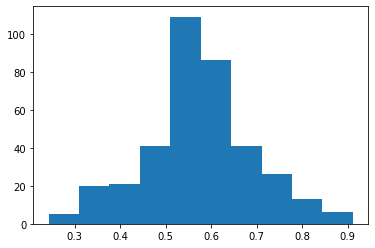

In [386]:
plt.hist(test_roc)

(array([ 1.,  4., 14., 47., 84., 98., 62., 36., 14.,  8.]),
 array([0.29260219, 0.34532145, 0.39804071, 0.45075998, 0.50347924,
        0.5561985 , 0.60891777, 0.66163703, 0.71435629, 0.76707556,
        0.81979482]),
 <BarContainer object of 10 artists>)

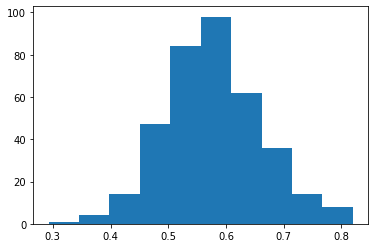

In [387]:
plt.hist(train_roc)


In [363]:
y.size()

torch.Size([3477, 1])

In [364]:
A.size()

torch.Size([3477, 3477])

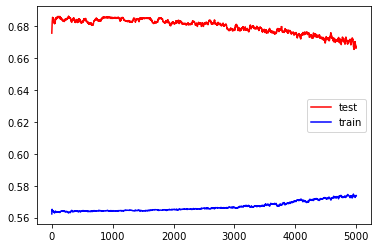

In [243]:
plt.figure()
plt.plot(test_roc, 'r-', label='test')
plt.plot(train_roc, 'b-', label='train')
plt.legend()
plt.show()

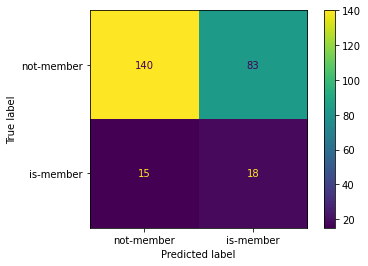

In [244]:
model = model.eval()
yhat = model(A, x)

cm = confusion_matrix(y[test_mask].detach().numpy(), yhat[test_mask].detach().numpy() > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-member', 'is-member'])
disp.plot()

In [245]:
roc_auc_score(y[test_mask].detach().numpy(), yhat[test_mask].detach().numpy())

0.6663948906101372

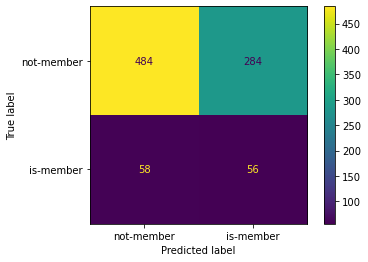

In [246]:
cm = confusion_matrix(y[train_mask].detach().numpy(), yhat[train_mask].detach().numpy() > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-member', 'is-member'])
disp.plot()